In [1]:
import torch
from torch import nn
import cv2
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import numpy as np
from torchvision import transforms as T


normal_images_train = [cv2.imread(os.path.join('./dataset/train', fn)) for fn in tqdm(os.listdir('./dataset/train'))]
images_test = [cv2.imread(os.path.join('./dataset/test/imgs', fn)) for fn in tqdm(os.listdir('./dataset/test/imgs'))]
abnormal_images = [cv2.imread(os.path.join('./dataset/proliv', fn)) for fn in tqdm(os.listdir('./dataset/proliv'))]

def initial_transforms(image):
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = torch.FloatTensor(image / 255).unsqueeze(0)
    image = T.Normalize(mean=0.5, std=0.5)(image)

    return image

normal_images_train = torch.stack(list(map(initial_transforms, normal_images_train)))
images_test = torch.stack(list(map(initial_transforms, images_test)))
abnormal_images = torch.stack(list(map(initial_transforms, abnormal_images)))

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

In [2]:
class DiscriminatorNet(nn.Module):
    def __init__(self, scale_factor):
        super(DiscriminatorNet, self).__init__()

        self.main = nn.Sequential(nn.Conv2d(1, int(8*scale_factor), 4, padding=1, stride=2, bias=False),
                                   nn.BatchNorm2d(int(8*scale_factor)),
                                   nn.LeakyReLU(0.2, inplace=True),
                                  
                                   nn.Conv2d(int(8*scale_factor), int(16*scale_factor), 4, padding=1, stride=2, bias=False),
                                   nn.BatchNorm2d(int(16*scale_factor)),
                                   nn.LeakyReLU(0.2, inplace=True),
                                  
                                   nn.Conv2d(int(16*scale_factor), int(32*scale_factor), 4, padding=1, stride=2, bias=False),
                                   nn.BatchNorm2d(int(32*scale_factor)),
                                   nn.LeakyReLU(0.2, inplace=True),
                                  
                                   nn.Conv2d(int(32*scale_factor), int(64*scale_factor), 4, padding=1, stride=2, bias=False),
                                   nn.BatchNorm2d(int(64*scale_factor)),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   
                                   nn.Conv2d(int(64*scale_factor), 1, 4, bias=False),
                                   nn.Sigmoid())
                                  

    def forward(self, x):
        return self.main(x)


class GeneratorNet(nn.Module):
    def __init__(self, scale_factor, noise_dim):
        super(GeneratorNet, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, scale_factor * 64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(scale_factor * 64),
            nn.ReLU(True),

            nn.ConvTranspose2d(scale_factor * 64, scale_factor * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(scale_factor * 32),
            nn.ReLU(True),

            nn.ConvTranspose2d(scale_factor * 32, scale_factor * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(scale_factor * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(scale_factor * 16, scale_factor * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(scale_factor * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(scale_factor * 8, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.main(z)

        return x

In [13]:
from torchinfo import summary

epochs = 1000
batch_size = 512
noise_dim = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device} device')

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator = GeneratorNet(scale_factor=8, noise_dim=noise_dim)
discriminator = DiscriminatorNet(scale_factor=8)

generator.apply(weights_init)
discriminator.apply(weights_init)

summary(generator, input_size=(batch_size, noise_dim, 1, 1), device='cpu')

using cuda device


Layer (type:depth-idx)                   Output Shape              Param #
GeneratorNet                             [512, 1, 64, 64]          --
├─Sequential: 1-1                        [512, 1, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [512, 512, 4, 4]          1,048,576
│    └─BatchNorm2d: 2-2                  [512, 512, 4, 4]          1,024
│    └─ReLU: 2-3                         [512, 512, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [512, 256, 8, 8]          2,097,152
│    └─BatchNorm2d: 2-5                  [512, 256, 8, 8]          512
│    └─ReLU: 2-6                         [512, 256, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [512, 128, 16, 16]        524,288
│    └─BatchNorm2d: 2-8                  [512, 128, 16, 16]        256
│    └─ReLU: 2-9                         [512, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [512, 64, 32, 32]         131,072
│    └─BatchNorm2d: 2-11                 [512, 64, 32, 3

In [14]:
summary(discriminator, input_size=(batch_size, 1, 64, 64), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
DiscriminatorNet                         [512, 1, 1, 1]            --
├─Sequential: 1-1                        [512, 1, 1, 1]            --
│    └─Conv2d: 2-1                       [512, 64, 32, 32]         1,024
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         128
│    └─LeakyReLU: 2-3                    [512, 64, 32, 32]         --
│    └─Conv2d: 2-4                       [512, 128, 16, 16]        131,072
│    └─BatchNorm2d: 2-5                  [512, 128, 16, 16]        256
│    └─LeakyReLU: 2-6                    [512, 128, 16, 16]        --
│    └─Conv2d: 2-7                       [512, 256, 8, 8]          524,288
│    └─BatchNorm2d: 2-8                  [512, 256, 8, 8]          512
│    └─LeakyReLU: 2-9                    [512, 256, 8, 8]          --
│    └─Conv2d: 2-10                      [512, 512, 4, 4]          2,097,152
│    └─BatchNorm2d: 2-11                 [512, 512, 4, 4]     

In [15]:
from torch.utils.data import TensorDataset, DataLoader


train_dataset = TensorDataset(normal_images_train)
abnormal_images_dataset = TensorDataset(abnormal_images)


train_loader = DataLoader(train_dataset, batch_size=batch_size)
# хочу по ходу обучения отследить динамику ошибки для нормальных и аномальных изображений
abnormal_images_loader = DataLoader(abnormal_images_dataset, batch_size=batch_size)

criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))

In [16]:
from tqdm.notebook import trange

generator_loss_train = list()
discriminator_loss_train = list()

generator = generator.to(device)
discriminator = discriminator.to(device)

for epoch in trange(epochs):
    discriminator.train()
    generator.train()

    generator_loss = 0
    discriminator_loss = 0

    for (real_img,) in train_loader:
        optimizerD.zero_grad()
        
        real_img = real_img.to(device)
        
        real_labels = torch.ones((real_img.shape[0],), device=device, dtype=torch.float) * 0.9
        fake_labels = torch.zeros((real_img.shape[0],), device=device, dtype=torch.float)

        real_pred = discriminator(real_img).squeeze(dim=(1, 2, 3))
        lossD_real = criterion(real_pred, real_labels)
        lossD_real.backward()

        z = torch.randn(real_img.shape[0], noise_dim, 1, 1).to(device)
        fake_img = generator(z)

        fake_pred = discriminator(fake_img.detach()).squeeze(dim=(1, 2, 3))
        lossD_fake = criterion(fake_pred, fake_labels)
        lossD_fake.backward()

        optimizerD.step()
        optimizerG.zero_grad()

        fake_pred = discriminator(fake_img).squeeze(dim=(1, 2, 3))
        lossG = criterion(fake_pred, real_labels)
        lossG.backward()

        optimizerG.step()

        generator_loss += lossG.item()
        discriminator_loss += lossD_fake.item() + lossD_real.item()

    if epoch % 20 == 0:
        print(f'Epoch: {epoch}/{epochs}, Generator loss: {round(generator_loss, 6)}, discriminator loss: {round(discriminator_loss, 6)}')

    generator_loss_train.append(generator_loss)
    discriminator_loss_train.append(discriminator_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0/1000, Generator loss: 209.314372, discriminator loss: 45.747819
Epoch: 20/1000, Generator loss: 28.785733, discriminator loss: 25.528429
Epoch: 40/1000, Generator loss: 24.733119, discriminator loss: 23.704696
Epoch: 60/1000, Generator loss: 25.859839, discriminator loss: 22.267444
Epoch: 80/1000, Generator loss: 31.124683, discriminator loss: 23.355523
Epoch: 100/1000, Generator loss: 33.876653, discriminator loss: 23.687708
Epoch: 120/1000, Generator loss: 30.891408, discriminator loss: 21.315024
Epoch: 140/1000, Generator loss: 32.122496, discriminator loss: 20.572886
Epoch: 160/1000, Generator loss: 30.685253, discriminator loss: 19.25086
Epoch: 180/1000, Generator loss: 34.955816, discriminator loss: 21.937427
Epoch: 200/1000, Generator loss: 34.70692, discriminator loss: 20.969746
Epoch: 220/1000, Generator loss: 34.066721, discriminator loss: 19.201649
Epoch: 240/1000, Generator loss: 30.699255, discriminator loss: 19.024035
Epoch: 260/1000, Generator loss: 33.374675, d

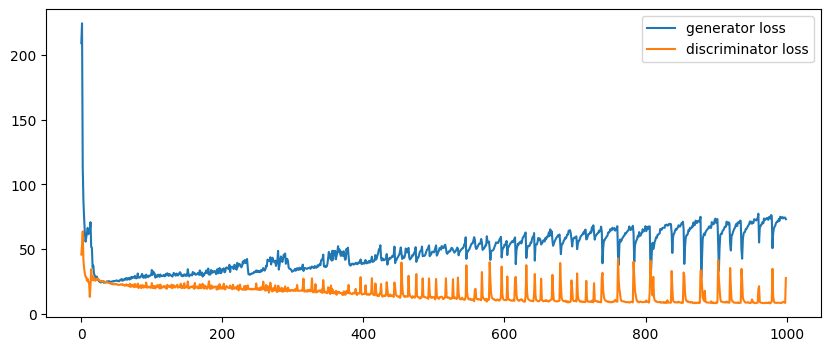

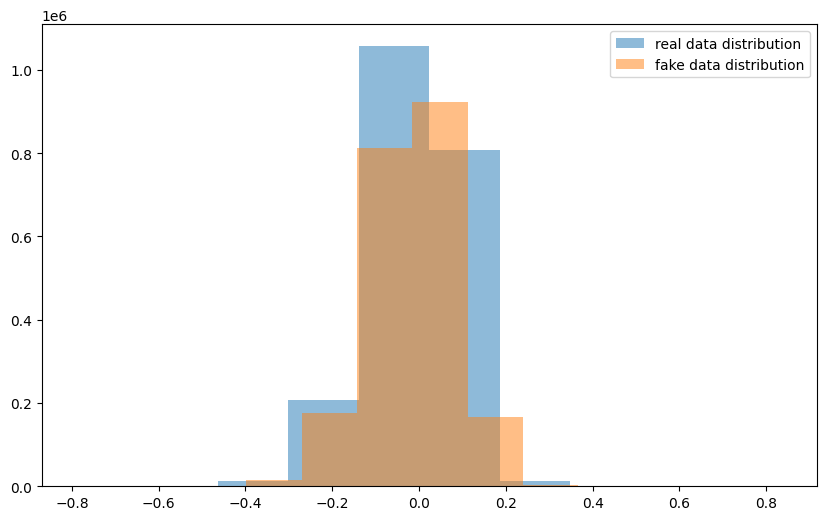

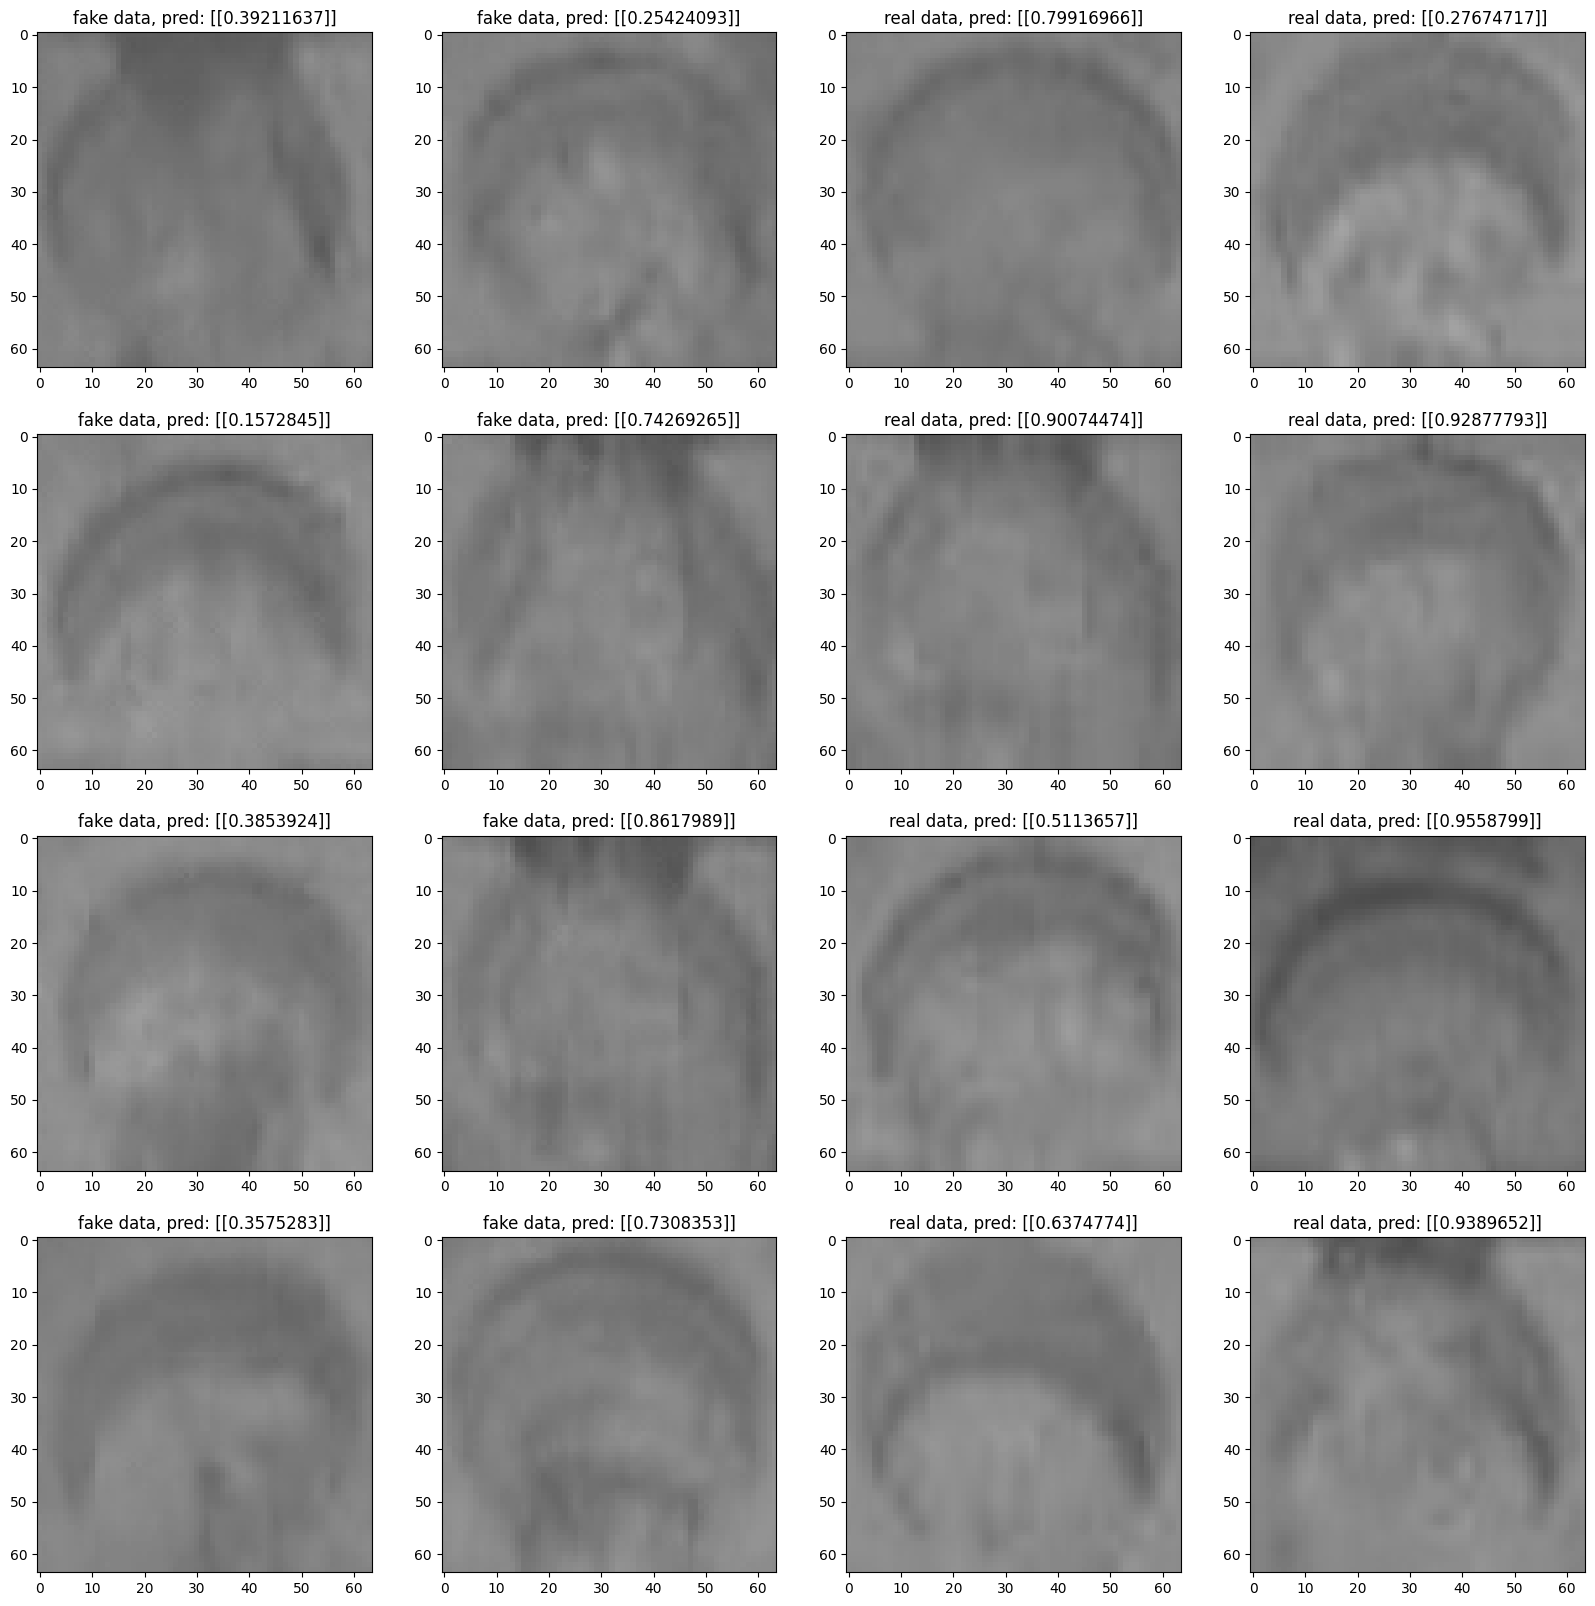

In [17]:
import matplotlib.pyplot as plt

z = torch.randn(batch_size, noise_dim, 1, 1).to(device)
fake_imgs = generator(z)
fake_imgs_preds = discriminator(fake_imgs.detach()).detach().cpu().numpy()
fake_imgs = fake_imgs.detach().cpu()

real_imgs = next(iter(train_loader))[0]
real_imgs_preds = discriminator(real_imgs.to(device)).detach().cpu().numpy()

fig = plt.figure(figsize=(10, 4))
plt.plot(generator_loss_train, label='generator loss')
plt.plot(discriminator_loss_train, label='discriminator loss')
plt.legend()

fig = plt.figure(figsize=(10, 6))
plt.hist(normal_images_train[:batch_size].view(-1), label='real data distribution', alpha = 0.5)
plt.hist(fake_imgs.view(-1), label='fake data distribution', alpha = 0.5)
plt.legend()

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))

for i in range(8):
    axes[i // 2, i % 2].imshow(fake_imgs[i][0].numpy(), cmap='gray', vmin=-1, vmax=1)
    axes[i // 2, i % 2].set_title(f'fake data, pred: {fake_imgs_preds[i][0]}')

for i in range(8):
    axes[i // 2, 2 + i % 2].imshow(real_imgs[i][0].numpy(), cmap='gray', vmin=-1, vmax=1)
    axes[i // 2, 2 + i % 2].set_title(f'real data, pred: {real_imgs_preds[i][0]}')

In [8]:
images_test = {fn: cv2.imread(os.path.join('./dataset/test/imgs', fn)) for fn in tqdm(os.listdir('./dataset/test/imgs'))}
with open('./dataset/test/test_annotation.txt') as f:
    lines = f.readlines()
    lines = [x.strip().split() for x in lines]

    markup = {x[0]: int(x[1]) for x in lines}

images_test = list(dict(sorted(images_test.items(), key=lambda x: x[0])).values())
images_test = torch.stack(list(map(initial_transforms, images_test)))
images_test = T.Normalize(mean=0.5, std=0.5)(images_test)

markup = np.array(list(dict(sorted(markup.items(), key=lambda x: x[0])).values()))

images_test.shape

  0%|          | 0/3794 [00:00<?, ?it/s]

torch.Size([3794, 1, 64, 64])

test data estimated threshold: 0.010101 with TPR=0.233 TNR=0.327


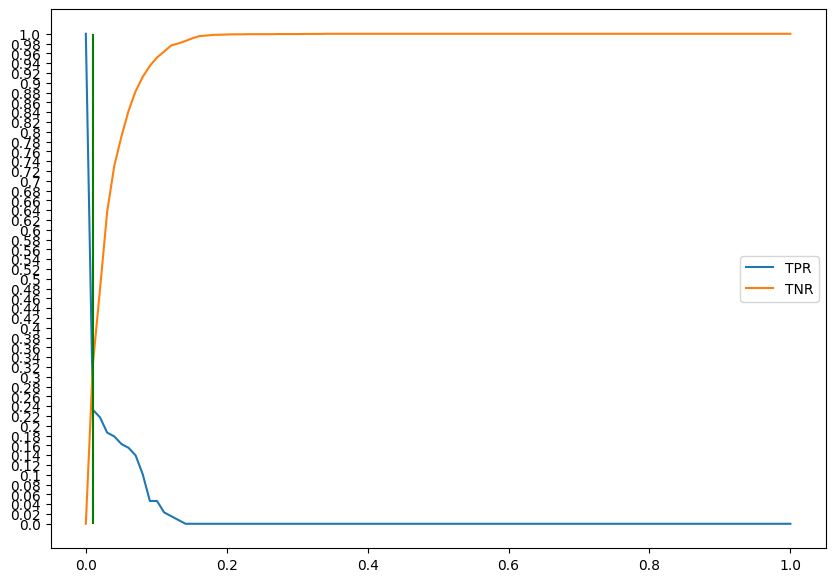

In [9]:
y_pred = discriminator(images_test.to(device)).detach().cpu().view(-1).numpy()

def calculate_metrics(y_pred, labels, thr):
    y_pred[y_pred < thr] = 0
    y_pred[y_pred > 0] = 1

    TP = ((y_pred + labels) == 2).sum()
    TN = ((y_pred + labels) == 0).sum()

    TPR = TP / (labels == 1).sum()
    TNR = TN / (labels == 0).sum()

    return TPR, TNR

TPRs = list()
TNRs = list()

linspace_params = (0, 1, 100)

for thr in np.linspace(*linspace_params):
    TPR, TNR = calculate_metrics(y_pred.copy(), markup, thr)
    
    TPRs.append(TPR)
    TNRs.append(TNR)

plt.figure(figsize=(10, 7))

plt.plot(np.linspace(*linspace_params), TPRs, label='TPR') 
plt.plot(np.linspace(*linspace_params), TNRs, label='TNR')

best_thr_test = np.linspace(*linspace_params)[np.argmin(np.abs(np.array(TPRs)-np.array(TNRs)))]
plt.vlines([best_thr_test], 0, 1, colors=['green'])

plt.yticks(np.round(np.linspace(0, 1, 51), 2), np.round(np.linspace(0, 1, 51), 2))

plt.legend()

TPR, TNR = calculate_metrics(y_pred, np.array(markup), best_thr_test)
print(f'test data estimated threshold: {round(best_thr_test, 6)} with TPR={round(TPR, 3)} TNR={round(TNR, 3)}')